# Analyse factorielle des correspondances

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

In [2]:
from fanalysis.ca import CA

In [3]:
### Lire le fichier corrigé manuellement – ne pas effacer !

path = 'data/observations_900.csv'

obs = pd.read_csv(path)
obs.set_index('id', inplace=True)
obs.head()

,age,gender,revenu_mensuel,lecture_journal,parti
id,,,,,
1,87,F,9410,trois-quatre fois par semaine,populiste
2,31,H,4466,de temps en temps,gauche
3,79,F,7515,trois-quatre fois par semaine,populiste
4,26,H,3376,le week-end,écologiste
5,75,F,3296,trois-quatre fois par semaine,gauche


In [4]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
# et coder les années de naissance en relation avec un découpage significatif au point de vue heuristique, et modifiable si besion
## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

generations = [18, 26, 36, 46, 56, 66, 91]
c_obs = obs.copy(deep=True)
c_obs['generation'] = pd.cut(c_obs['age'], generations, right=False)
# Inspection
c_obs.head()

,age,gender,revenu_mensuel,lecture_journal,parti,generation
id,,,,,,
1,87,F,9410,trois-quatre fois par semaine,populiste,"[66, 91)"
2,31,H,4466,de temps en temps,gauche,"[26, 36)"
3,79,F,7515,trois-quatre fois par semaine,populiste,"[66, 91)"
4,26,H,3376,le week-end,écologiste,"[26, 36)"
5,75,F,3296,trois-quatre fois par semaine,gauche,"[66, 91)"


## Age et orientation politique

### Tableau de contingence

In [5]:
### La fonction pivot_table produit un tableau de contingence
## Au centre du tableau se trouvent les effectifs conjoints, 
## aux bords les effectifs marginaux qui correspondent 
## aux distributions indépendantes des variables

X = "parti"  # "0"
Y = "generation"

ddf = c_obs[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

parti,centre,droite,gauche,populiste,écologiste,Total
generation,,,,,,
"[18, 26)",16,17,22,22,33,110
"[26, 36)",18,22,22,31,36,129
"[36, 46)",20,21,18,17,18,94
"[46, 56)",31,15,21,32,32,131
"[56, 66)",20,24,24,19,36,123
"[66, 91)",57,55,62,78,61,313
Total,162,154,169,199,216,900


In [6]:
D = ddf.iloc[:-1,:-1].copy(deep=True)
D

parti,centre,droite,gauche,populiste,écologiste
generation,,,,,
"[18, 26)",16,17,22,22,33
"[26, 36)",18,22,22,31,36
"[36, 46)",20,21,18,17,18
"[46, 56)",31,15,21,32,32
"[56, 66)",20,24,24,19,36
"[66, 91)",57,55,62,78,61


In [7]:
## Nombre de modalités ligne, 
# variable: catégories socio-professionnelles des parents
K = D.shape[0]
## Nombre de modalités colonnes,
# variable : filière d'études chosie
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 6 , 5 ), effectif: 900 , nombre max. facteurs: 4


In [8]:
### Valeurs produites par une fonction
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[:-1,:-1], method='cramer')
print('Cramer: ', vc)

Chi2 : 23.14534620812505 , dof : 20
p-value : 0.2817142212155052
phi2 = inertie (variance totale) : 0.02571705134236117
Cramer:  0.09901590006275432


### Commentaire

Noter la p value haute, 28%, on ne peut pas rejeter l'hypothèse d'indépendance. 

On pourrait donc s'arrêter ici, mais on profite des axes factoriels pour prendre connaissance des tendances 

In [9]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['centre', 'droite', 'gauche', 'populiste', 'écologiste'], dtype='object', name='parti'),
   row_labels=Index([[18, 26), [26, 36), [36, 46), [46, 56), [56, 66), [66, 91)], dtype='object', name='generation'))

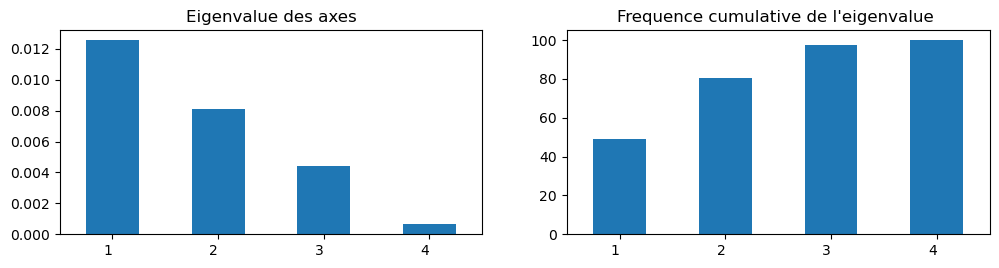

In [10]:
eig = pd.DataFrame(afc.eig_)

r1 = eig.iloc[0]
r2 = eig.iloc[2]
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

### Distances des lignes / des colonnes

In [11]:
# Calcul des profils des lignes
prof_lig = np.apply_along_axis(arr=D.values,axis=1,
                               func1d=lambda x:x/np.sum(x))
# Calul du profil marginal correspondant
# Cf. ligne grisée de Figure 100, Rakotomalala, 2020
tot_col = ddf.loc['Total'][:5]
prof_marg_lig = tot_col/np.sum(tot_col)

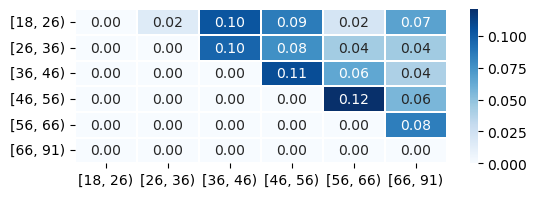

In [12]:
### Distance entre paires de modalités lignes,
# calculée sur la base des valeurs dans la note précédente

fig, ax = plt.subplots(figsize=(6,2))

distPairesLig = np.zeros(shape=(prof_lig.shape[0],prof_lig.shape[0]))
#double boucle
for i in range(prof_lig.shape[0]):
    for j in range(i+1,prof_lig.shape[0]):
        distPairesLig[i,j] = np.sum((prof_lig[i,:]-prof_lig[j,:])**2/prof_marg_lig)

sns.heatmap(distPairesLig,vmin=0,vmax=np.max(distPairesLig),linewidth=0.1,cmap=
'Blues',xticklabels=D.index,yticklabels=D.index,
fmt=".2f", annot=True)


### ATTENTION: plus la couleur est foncée, plus la distance est grande
plt.show()

In [13]:
# Profil marginal des filières (colonnes)
tot_lig = np.sum(D.values,axis=1)
prof_marg_col = tot_lig/np.sum(tot_lig)

# Tableau des profils colonnes
prof_col = np.apply_along_axis(arr=D.values,axis=0,
                               func1d=lambda x:x/np.sum(x))
#print(pd.DataFrame(prof_col,index=D.index,columns=D.columns))
### Transposer pour garder la structure du code Python des lignes 
t_prof_col = prof_col.T

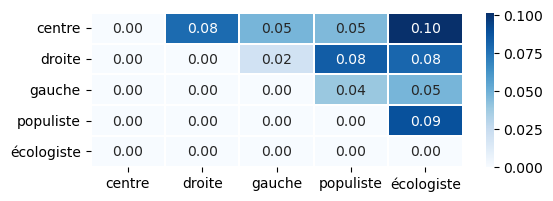

In [14]:
### Distance entre paires de modalités colonnes,
# calculée sur la base des valeurs précédentes  

fig, ax = plt.subplots(figsize=(6,2))


distPairesCol = np.zeros(shape=(t_prof_col.shape[0],
                                t_prof_col.shape[0]))
#double boucle
for i in range(t_prof_col.shape[0]-1):
    for j in range(i+1,t_prof_col.shape[0]):        
        distPairesCol[i,j] = np.sum((t_prof_col[i,:]-t_prof_col[j,:])**2/prof_marg_col)
#distPairesLig[j,i] = distPairesLig[i,j]
#affichage
#print(pd.DataFrame(distPairesLig,index=D.index,columns=D.index))

sns.heatmap(distPairesCol,vmin=0,vmax=np.max(distPairesCol),
            linewidth=0.1,cmap='Blues',xticklabels=D.columns,
            yticklabels=D.columns, 
fmt=".2f", annot=True)

plt.show()

### Graphiques et interprétation du premier plan factoriel

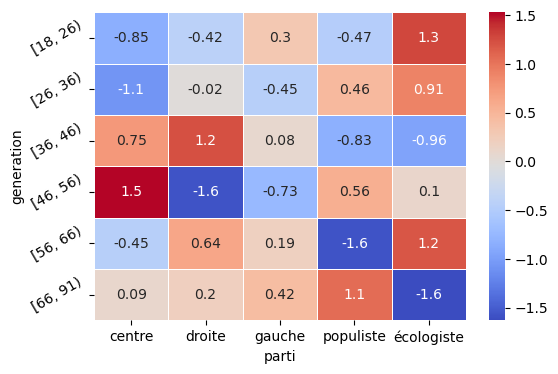

In [15]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(6,4))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labels = residus_ponderes.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()


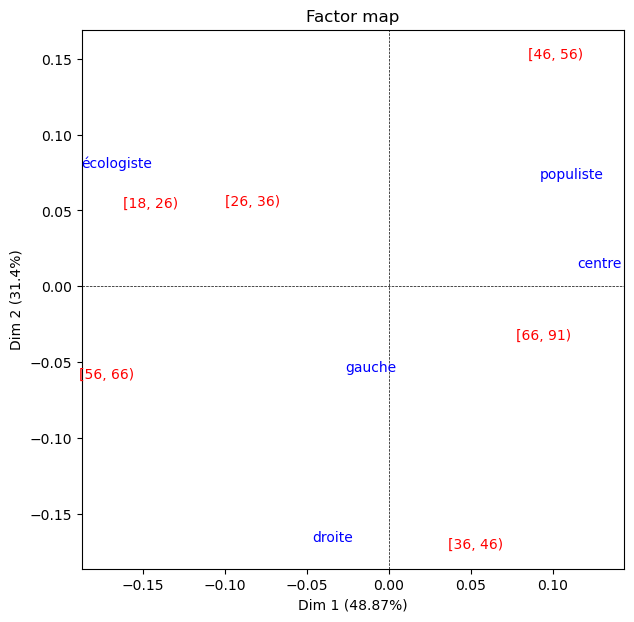

In [16]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(7,7))

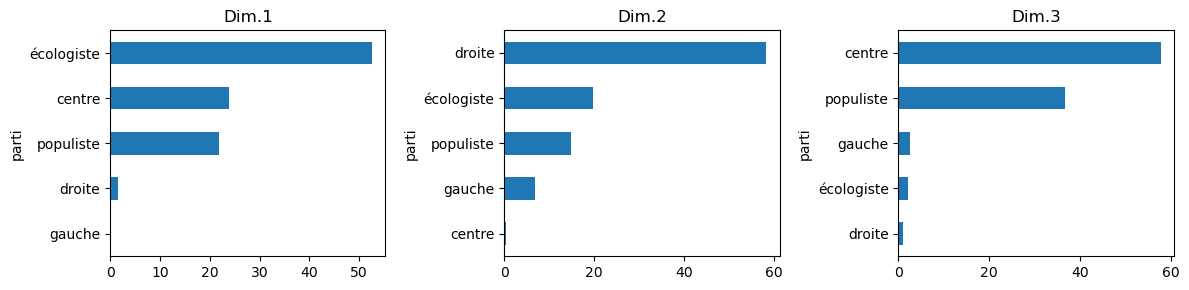

In [24]:
# Informations sur les contributions des colonnes
df = afc.col_topandas()[['col_contrib_dim1',
                         'col_contrib_dim2',
                         'col_contrib_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))


r1.sort_values().plot(kind='barh', ax=axes[0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[2], title='Dim.3')


plt.tight_layout()
plt.show()


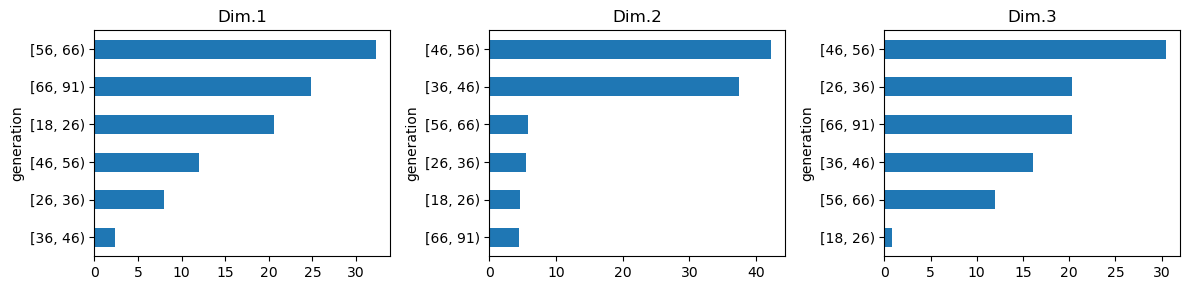

In [23]:
# Informations sur les contributions des lignes
df = afc.row_topandas()[['row_contrib_dim1',
                         'row_contrib_dim2',
                         'row_contrib_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))


r1.sort_values().plot(kind='barh', ax=axes[0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[2], title='Dim.3')

plt.tight_layout()
plt.show()


### Représenter l'autre plan factoriel

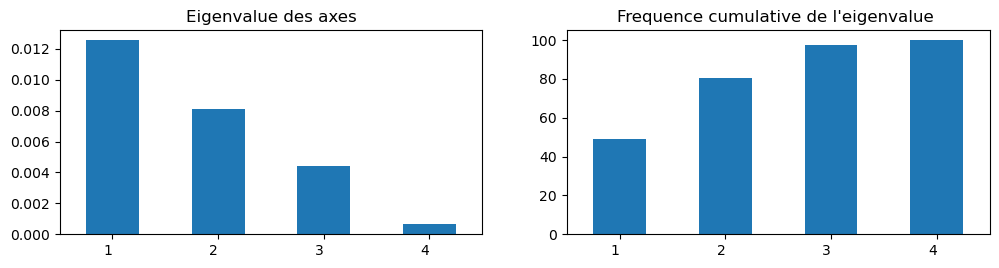

In [17]:
eig = pd.DataFrame(afc.eig_)

r1 = eig.iloc[0]
r2 = eig.iloc[2]
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

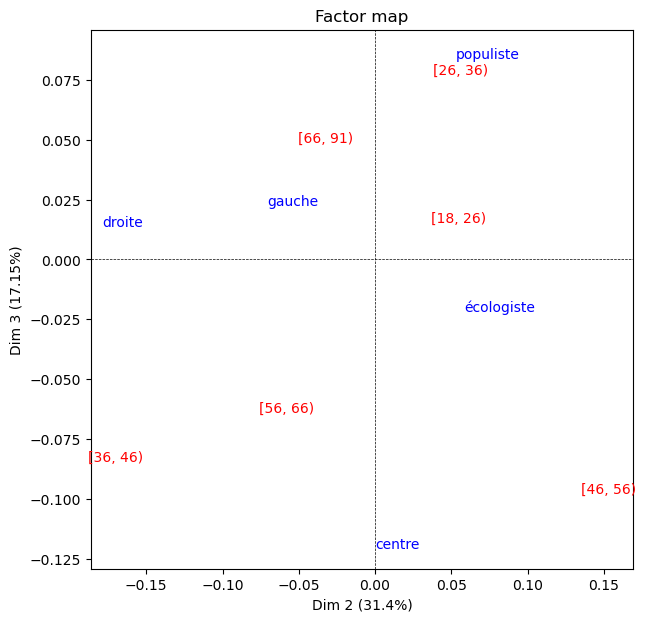

In [18]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=2,num_y_axis=3,figsize=(7,7))

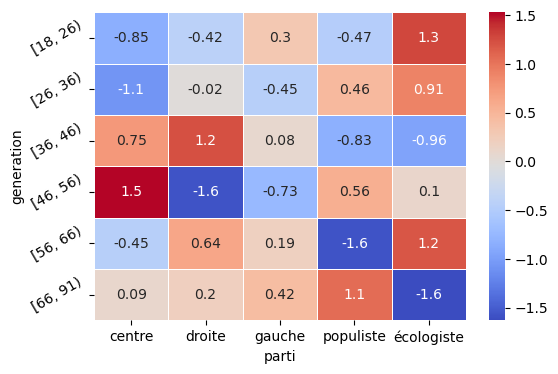

In [27]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(6,4))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labels = residus_ponderes.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()


In [26]:
## Pour afficher les coordonnées
# afc.row_topandas().iloc[:,:3]
# afc.col_topandas().iloc[:,:3]

---------

## Genre et orientation politique

In [28]:
X = "gender"
Y = "parti"  # "0"

ddf = c_obs[[Y,X]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int) 
ddf

parti,centre,droite,gauche,populiste,écologiste,Total
gender,,,,,,
F,88,59,114,97,138,496
H,74,95,55,102,78,404
Total,162,154,169,199,216,900


In [29]:
D = ddf.iloc[:-1,:-1].copy(deep=True)
D

parti,centre,droite,gauche,populiste,écologiste
gender,,,,,
F,88,59,114,97,138
H,74,95,55,102,78


In [30]:
## Nombre de modalités ligne, 
# variable: catégories socio-professionnelles des parents
K = D.shape[0]
## Nombre de modalités colonnes,
# variable : filière d'études chosie
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 2 , 5 ), effectif: 900 , nombre max. facteurs: 1


In [31]:
### Valeurs produites par une fonction
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 38.00810570059225 , dof : 4
p-value : 1.1162531734956683e-07
phi2 = inertie (variance totale) : 0.04223122855621361
Cramer:  0.20550238090156914


In [32]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['centre', 'droite', 'gauche', 'populiste', 'écologiste'], dtype='object', name='parti'),
   row_labels=Index(['F', 'H'], dtype='object', name='gender'))

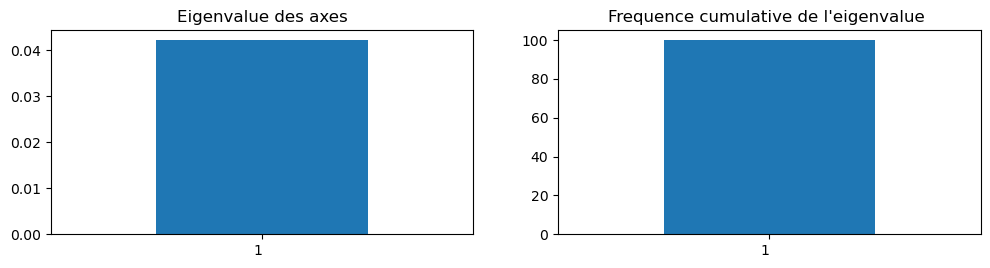

In [33]:
eig = pd.DataFrame(afc.eig_)

r1 = eig.iloc[0]
r2 = eig.iloc[2]
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

### Commentaire

Pas la peine de poursuivre, seulement deux modalités pour la variable genre, et un seul axe factoriel

--------

## Orientation politique et fréquence de lecture du journal

In [34]:
X = "parti"  # "0"
Y = "lecture_journal"

ddf = c_obs[[Y,X]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int) 
ddf

lecture_journal,de temps en temps,le week-end,tous les jours,trois-quatre fois par semaine,très rarement,Total
parti,,,,,,
centre,22,42,51,33,14,162
droite,8,23,58,57,8,154
gauche,35,33,37,32,32,169
populiste,59,40,15,33,52,199
écologiste,14,71,71,41,19,216
Total,138,209,232,196,125,900


In [35]:
ddf = ddf[['très rarement', 'de temps en temps', 'le week-end', 'trois-quatre fois par semaine', 'tous les jours','Total']]
ddf.columns = ['très rar', 'de temps', 'le week-end', 'trois-quatre', 'tous les','Total']

In [36]:
D = ddf.iloc[:-1,:-1].copy(deep=True)
D

,très rar,de temps,le week-end,trois-quatre,tous les
parti,,,,,
centre,14,22,42,33,51
droite,8,8,23,57,58
gauche,32,35,33,32,37
populiste,52,59,40,33,15
écologiste,19,14,71,41,71


In [37]:
## Nombre de modalités ligne, 
# variable: catégories socio-professionnelles des parents
K = D.shape[0]
## Nombre de modalités colonnes,
# variable : filière d'études chosie
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 5 , 5 ), effectif: 900 , nombre max. facteurs: 4


In [38]:
### Valeurs produites par une fonction
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[:-1,:-1], method='cramer')
print('Cramer: ', vc)

Chi2 : 169.01518926544836 , dof : 16
p-value : 1.323478734917736e-27
phi2 = inertie (variance totale) : 0.18779465473938706
Cramer:  0.2239636545513354


In [39]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['très rar', 'de temps', 'le week-end', 'trois-quatre', 'tous les'], dtype='object'),
   row_labels=Index(['centre', 'droite', 'gauche', 'populiste', 'écologiste'], dtype='object', name='parti'))

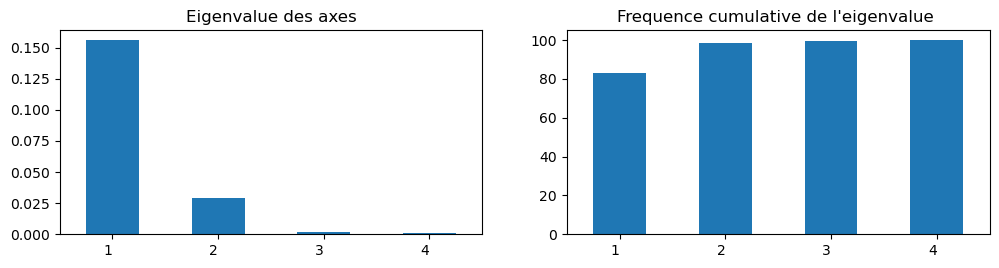

In [40]:
eig = pd.DataFrame(afc.eig_)

r1 = eig.iloc[0]
r2 = eig.iloc[2]
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

### Distances des lignes / des colonnes

In [41]:
# Calcul des profils des lignes
prof_lig = np.apply_along_axis(arr=D.values,axis=1,
                               func1d=lambda x:x/np.sum(x))
# Calul du profil marginal correspondant
# Cf. ligne grisée de Figure 100, Rakotomalala, 2020
tot_col = ddf.loc['Total'][:5]
prof_marg_lig = tot_col/np.sum(tot_col)

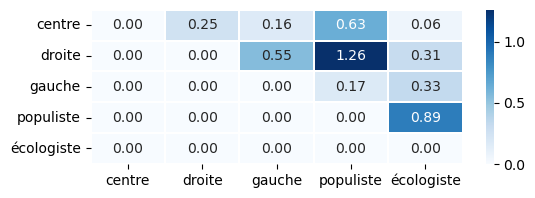

In [42]:
### Distance entre paires de modalités lignes,
# calculée sur la base des valeurs dans la note précédente

fig, ax = plt.subplots(figsize=(6,2))

distPairesLig = np.zeros(shape=(prof_lig.shape[0],prof_lig.shape[0]))
#double boucle
for i in range(prof_lig.shape[0]):
    for j in range(i+1,prof_lig.shape[0]):
        distPairesLig[i,j] = np.sum((prof_lig[i,:]-prof_lig[j,:])**2/prof_marg_lig)

sns.heatmap(distPairesLig,vmin=0,vmax=np.max(distPairesLig),linewidth=0.1,cmap=
'Blues',xticklabels=D.index,yticklabels=D.index,
fmt=".2f", annot=True)


### ATTENTION: plus la couleur est foncée, plus la distance est grande
plt.show()

In [43]:
# Profil marginal des filières (colonnes)
tot_lig = np.sum(D.values,axis=1)
prof_marg_col = tot_lig/np.sum(tot_lig)

# Tableau des profils colonnes
prof_col = np.apply_along_axis(arr=D.values,axis=0,
                               func1d=lambda x:x/np.sum(x))
#print(pd.DataFrame(prof_col,index=D.index,columns=D.columns))
### Transposer pour garder la structure du code Python des lignes 
t_prof_col = prof_col.T

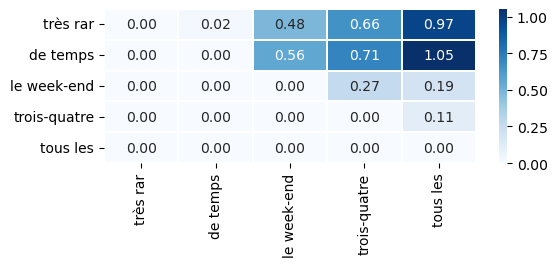

In [44]:
### Distance entre paires de modalités colonnes,
# calculée sur la base des valeurs précédentes  

fig, ax = plt.subplots(figsize=(6,2))


distPairesCol = np.zeros(shape=(t_prof_col.shape[0],
                                t_prof_col.shape[0]))
#double boucle
for i in range(t_prof_col.shape[0]-1):
    for j in range(i+1,t_prof_col.shape[0]):        
        distPairesCol[i,j] = np.sum((t_prof_col[i,:]-t_prof_col[j,:])**2/prof_marg_col)
#distPairesLig[j,i] = distPairesLig[i,j]
#affichage
#print(pd.DataFrame(distPairesLig,index=D.index,columns=D.index))

sns.heatmap(distPairesCol,vmin=0,vmax=np.max(distPairesCol),
            linewidth=0.1,cmap='Blues',xticklabels=D.columns,
            yticklabels=D.columns, 
fmt=".2f", annot=True)

plt.show()

### Graphiques et interprétation du premier plan factoriel

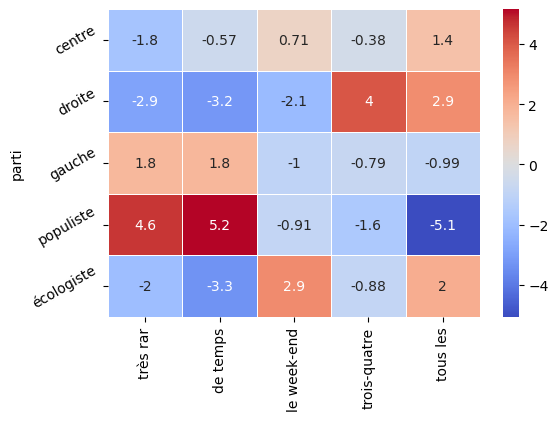

In [45]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(6,4))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labels = residus_ponderes.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()


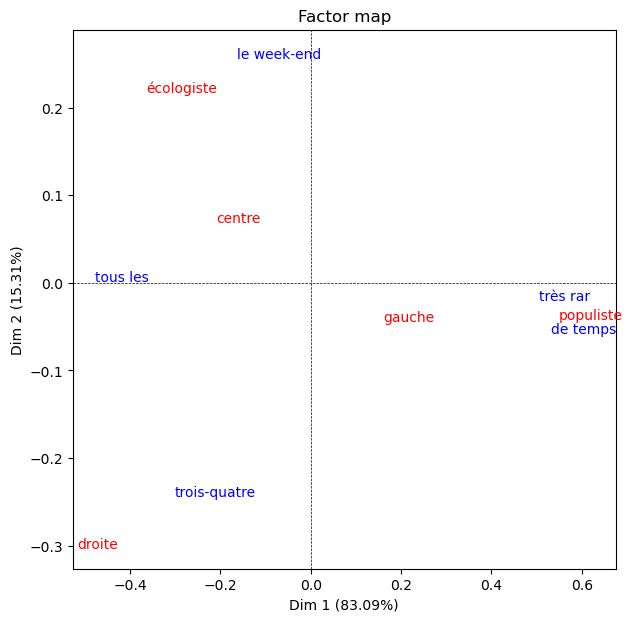

In [46]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(7,7))

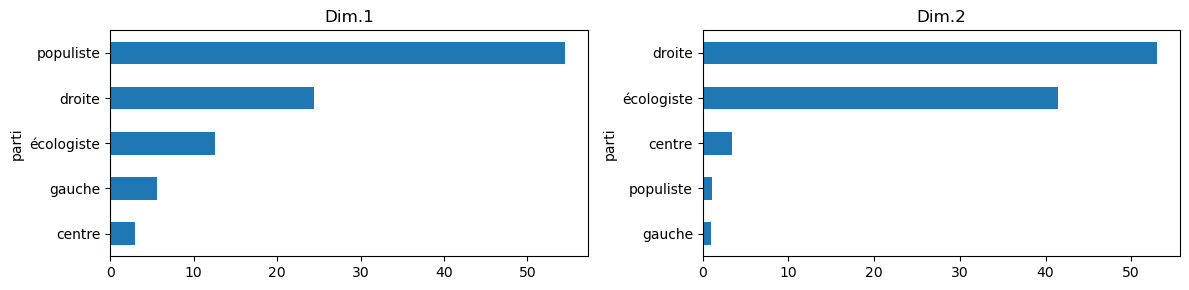

In [47]:
# Informations sur les contributions des lignes
df = afc.row_topandas()[['row_contrib_dim1',
                         'row_contrib_dim2']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))


r1.sort_values().plot(kind='barh', ax=axes[0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1], title='Dim.2')

plt.tight_layout()
plt.show()


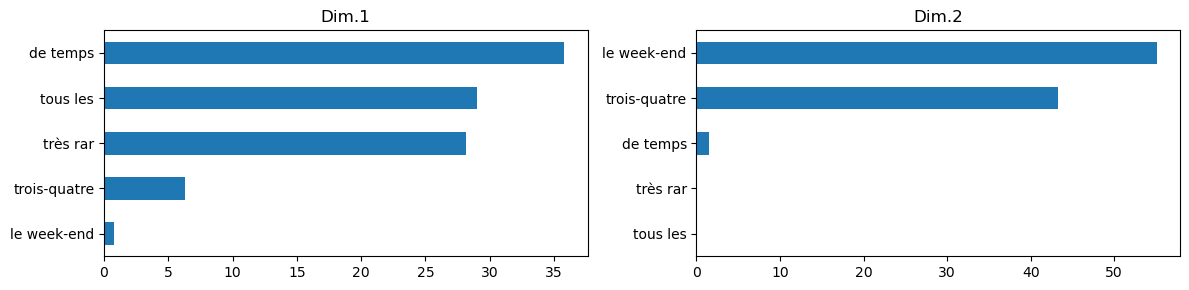

In [48]:
# Informations sur les contributions des colonnes
df = afc.col_topandas()[['col_contrib_dim1',
                         'col_contrib_dim2']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]


# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))


r1.sort_values().plot(kind='barh', ax=axes[0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1], title='Dim.2')


plt.tight_layout()
plt.show()
